# Let's generate some data from a state space model

In [1]:
using Distributions
using PyPlot
srand(12345)  # set random number seed

INFO: Loading help data...


We'll generate data according to a simple state space model and then recover the underlying model via the Kalman filter/smoother. We follow the conventions of [Durbin and Koopman (2012)](http://www.ssfpack.com/DKbook.html).

## Observation model

$$\begin{align}
y_t &= Z_t \alpha_t + \varepsilon_t \\
\varepsilon_t &\sim \mathcal{N}(0, H_t)
\end{align}$$

In [2]:
Z = [1 -1 ; 0 1 ; 1 0]
H = [1 0 0 ; 0 1 0.2 ; 0 0.2 1]

Np, Nm = size(Z);

In [3]:
assert(size(H) == (Np, Np))

## State evolution model

$$
\begin{align}
\alpha_{t+1} &= T_t \alpha_t + R_t \eta_t \\
\eta_t &\sim \mathcal{N}(0, Q_t)
\end{align}$$

In [4]:
th = 10 * pi / 180
T = [cos(th) sin(th) ; -sin(th) cos(th)]
R = [1.1 1]'
Q = [0.05]

_, Nr = size(R);

In [5]:
assert(size(T) == (Nm, Nm))

## Prior
$$
\alpha_1 \sim \mathcal{N}(a_1, P_1)
$$

In [6]:
a_init = zeros(Nm)
P_init = 5 * eye(Nm);

In [7]:
assert(size(P_init) == (Nm, Nm))

# Now generate some data

In [8]:
Nt = 100  # number of samples

100

In [9]:
# preallocate
α = Array(Float64, Nm, Nt);
y = Array(Float64, Np, Nt);
ϵ = Array(Float64, Np, Nt);
η = Array(Float64, Nr, Nt);

Initialize:

In [11]:
α[:, 1] = rand(MvNormal(a_init, P_init));

In [12]:
ϵrng = MvNormal(H)
ηrng = MvNormal(Q)
for t in 1:Nt
    ϵ[:, t] = rand(ϵrng)
    η[:, t] = rand(ηrng)
    
    y[:, t] = Z * α[:, t] + ϵ[:, t]
    
    if t + 1 <= Nt
        α[:, t + 1] = T * α[:, t] + R * η[:, t]
    end
end

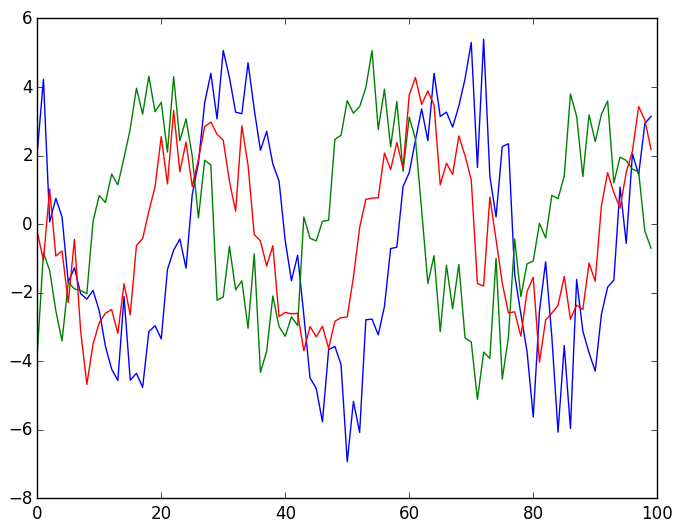

In [14]:
plot(y');

# Kalman filter (forward)

Now filter! In DK conventions, this is
$$\begin{align}
v_t &= y_t - Z_t a_t  \\
F_t &= Z_t P_t Z_t^\top + H_t  \\
aa \equiv \mathbb{E}(\alpha_t\vert y_{1:t}) &= a_t + P_t Z_t^\top F_t^{-1} v_t  \\
PP \equiv \mathrm{var}(\alpha_t \vert y_{1:t}) &= P_t - P_t Z_t^\top F_t^{-1} Z_t P_t  \\
K_t &= T_t P_t Z_t^\top F_t^{-1}  \\
L_t &= T_t - K_t Z_t  \\
a_{t + 1} &= T_t a_t + K_t v_t  \\
P_{t + 1} &= T_t P_t(T_t - K_t Z_t)^\top + R_t Q_t R_t^\top
\end{align}$$

In [15]:
#preallocate

a = Array(Float64, Nm, Nt);
P = Array(Float64, Nm, Nm, Nt);
aa = Array(Float64, Nm, Nt);
PP = Array(Float64, Nm, Nm, Nt);
v = Array(Float64, Np, Nt);
F = Array(Float64, Np, Np, Nt);
K = Array(Float64, Nm, Np, Nt);
L = Array(Float64, Nm, Nm, Nt);

In [16]:
# set priors
a[:, 1] = a_init;
P[:, :, 1] = P_init;

In [18]:
# iterate

for t in 1:Nt
    v[:, t] = y[:, t] - Z * a[:, t]
    Ft = Z * P[:, :, t] * Z' + H
    F[:, :, t] = Ft
    Finv = inv(Ft)
    aa[:, t] = a[:, t] + P[:, :, t] * Z' * Finv * v[:, t]
end